
# 🥗 SemantiCLIP : Analyse Comparative Zero-Shot vs Few-Shot sur Food-101

### 1. Contexte et Théorie

L'apprentissage profond traditionnel repose sur l'entraînement supervisé, cependant, cette approche est limitée par la quantité de données étiquetées disponibles.

Ce projet explore une approche différente basée sur **CLIP (Contrastive Language-Image Pre-training)** d'OpenAI.
Contrairement aux réseaux de neurones classiques (CNN), CLIP est un modèle **multimodal** entraîné sur 400 millions de paires (image, texte). Sa force réside dans sa capacité à projeter des images et du texte dans un **même espace sémantique partagé** (un espace vectoriel à 512 dimensions).

Dans cet espace, l'image d'une pizza et le texte "une photo de pizza" sont mathématiquement proches (leur similarité cosinus est élevée), tandis qu'ils sont éloignés du texte "une photo de sushi". Cela permet de classifier des images sans jamais les avoir vues lors de l'entraînement spécifique : c'est le **Zero-Shot Learning**.

### 2. Objectifs de l'Étude

L'objectif de ce projet est de comparer la "culture générale" d'un modèle de fondation (CLIP) face à un apprentissage spécialisé sur peu de données.
Nous cherchons à répondre à la question suivante :

> *Est-il préférable d'utiliser les connaissances pré-existantes de CLIP (Zero-Shot) ou d'entraîner un classifieur spécifique sur quelques exemples (Few-Shot / Linear Probing) ?*

Nous utilisons pour cela un sous-ensemble du dataset **Food-101** filtré sur 10 classes distinctes (Pizza, Sushi, Tacos, etc.).

### 3. Méthodologie et Étapes du Projet

Le projet suit un pipeline de Data Science rigoureux :

1. **Préparation des Données :** Téléchargement et filtrage du dataset Food-101 pour ne garder que 10 classes cibles.


2. **Feature Extraction :** Utilisation de l'encodeur visuel de CLIP (`ViT-B/32`) pour transformer les images en vecteurs d'embeddings.


3. **Classification Zero-Shot :** Création de "prompts" textuels (ex: *"a photo of a pizza"*) et comparaison directe avec les images via similarité cosinus.


4. **Linear Probing (Few-Shot) :** Entraînement d'une Régression Logistique sur les embeddings extraits, en faisant varier le nombre d'exemples d'entraînement (1-shot, 5-shots).


5. **Optimisation :** Recherche des meilleurs hyperparamètres (Grid Search) pour maximiser la performance du Few-Shot.
6. **Analyse et Visualisation :** Comparaison des performances via des matrices de confusion et visualisation de l'espace sémantique (t-SNE/PCA).



---

In [47]:
# !pip install git+https://github.com/openai/CLIP.git
# !pip install torch torchvision


### Initialisation 

In [48]:
# --- Imports ---
import os
import shutil
import ssl
import torch
import clip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from torchvision.datasets import Food101, ImageFolder
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# --- Configuration Système ---
# Contournement SSL pour le téléchargement des données
ssl._create_default_https_context = ssl._create_unverified_context

# Détection automatique du hardware (Mac M1/M2/M3, NVIDIA ou CPU)
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Device utilisé : {device}")

# Chargement du modèle CLIP (ViT-B/32)
print("Chargement du modèle CLIP...")
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval() # Mode évaluation (pas de dropout, etc.)
print("Modèle chargé.")

Device utilisé : mps
Chargement du modèle CLIP...
Modèle chargé.


### Téléchargement et Filtrage de Food-101

In [49]:
# # 1. Téléchargement (seulement si nécessaire)
# full_train_ds = Food101(root="./data", split="train", download=True, transform=preprocess)
# full_test_ds = Food101(root="./data", split="test", download=True, transform=preprocess)

In [50]:
# Configuration des chemins
source_path = "./data"
filtered_path = "./data_filtered"
target_classes = ['pizza', 'hamburger', 'sushi', 'tacos', 'apple_pie', 
                  'ice_cream', 'omelette', 'french_fries', 'guacamole', 'paella']

def create_filtered_dataset(split, max_samples=200):
    split_path = os.path.join(filtered_path, split)
    
    if os.path.exists(split_path):
        print(f"✅ Dossier {split} déjà existant dans {filtered_path}")
        return

    print(f"📂 Création du dataset filtré ({split})...")
    # On charge le dataset original sans transformation pour copier les fichiers bruts
    full_ds = Food101(root=source_path, split=split, download=True)
    
    class_counts = {c: 0 for c in target_classes}
    target_indices = {full_ds.class_to_idx[c]: c for c in target_classes}

    for i in tqdm(range(len(full_ds))):
        _, label = full_ds[i]
        
        if label in target_indices:
            class_name = target_indices[label]
            if class_counts[class_name] < max_samples:
                # Créer le dossier de la classe
                os.makedirs(os.path.join(split_path, class_name), exist_ok=True)
                
                # Récupérer le chemin de l'image originale
                img_path = full_ds._image_files[i]
                dest_path = os.path.join(split_path, class_name, os.path.basename(img_path))
                
                # Copier le fichier
                shutil.copy(img_path, dest_path)
                class_counts[class_name] += 1
        
        if all(count >= max_samples for count in class_counts.values()):
            break

# Exécution pour Train et Test
create_filtered_dataset("train", max_samples=200)
create_filtered_dataset("test", max_samples=50)

✅ Dossier train déjà existant dans ./data_filtered
✅ Dossier test déjà existant dans ./data_filtered


### Chargement du Dataset filtré

In [51]:
# On utilise le 'preprocess' de CLIP comme transformation
train_ds = ImageFolder(root=os.path.join(filtered_path, "train"), transform=preprocess)
test_ds = ImageFolder(root=os.path.join(filtered_path, "test"), transform=preprocess)

print(f"Classes chargées : {train_ds.classes}")
print(f"Total images : {len(train_ds)} (Train) / {len(test_ds)} (Test)")

Classes chargées : ['apple_pie', 'french_fries', 'guacamole', 'hamburger', 'ice_cream', 'omelette', 'paella', 'pizza', 'sushi', 'tacos']
Total images : 2000 (Train) / 500 (Test)


---

### **Etape 1: Zero-Shot** 

1. Définir les prompts : Créer une liste de phrases comme "une photo de pizza".
2. Encoder le texte : Transformer ces phrases en vecteurs (embeddings) avec model.encode_text.
3. Comparer : Pour chaque image du set de test, calculer sa similarité avec tes 10 phrases. La phrase la plus proche donne la prédiction.
4. Calculer l'Accuracy : Comparer ces prédictions aux vrais labels.



#### 1. Préparation des prompts

##### Historique : Ancienne méthode (Single Prompt)
Voici le code utilisé avant l'implémentation du Prompt Ensembling :

```python
# On récupère l'ordre exact des classes chargées par ImageFolder
class_names = test_ds.classes 
print(f"Ordre des classes : {class_names}")

# Création des prompts avec un template simple
templates = [f"a photo of {c}, a type of food" for c in class_names]
print(f"Exemple de prompt : {templates[0]}")

In [52]:
class_names = test_ds.classes 

clip_templates = [
    "a photo of a {}.",
    "a bad photo of a {}.",
    "a photo of many {}.",
    "art of the {}.",
    "a close-up photo of a {}.",
    "a delicious {}.",
    "a photo of the {}.",
    "the {}.",
    "a rendition of a {}.",
    "a cropped photo of the {}.",
    "a pixelated photo of the {}.",
]


#### 2. Encodage du texte

##### Historique : Ancienne méthode (Single Prompt)
```python 
# Tokenisation et Encodage
text_tokens = clip.tokenize(templates).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    # Normalisation pour le calcul de la similarité cosinus
    text_features /= text_features.norm(dim=-1, keepdim=True)

print(f"Dimensions des features texte : {text_features.shape}") # [10, 512]

In [53]:
def encode_text_with_ensemble(model, class_names, templates, device):
    zeroshot_weights = []
    
    with torch.no_grad():
        for class_name in class_names:
            # 1. Créer une liste de prompts pour cette classe spécifique (remplace {} par le nom)
            # On remplace les underscores par des espaces pour aider CLIP (ex: "apple_pie" -> "apple pie")
            name_clean = class_name.replace("_", " ") 
            texts = [template.format(name_clean) for template in templates] 
            
            # 2. Tokenizer et Encoder
            texts_tokenized = clip.tokenize(texts).to(device) 
            class_embeddings = model.encode_text(texts_tokenized) 
            
            # 3. Normaliser chaque template
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            
            # 4. Méthode Ensembling - Faire la MOYENNE des vecteurs 
            class_embedding = class_embeddings.mean(dim=0)
            
            # 5. Renormaliser le vecteur moyen final
            class_embedding /= class_embedding.norm()
            
            zeroshot_weights.append(class_embedding)
            
    # On empile pour avoir un tenseur de forme [nombre_classes, 512]
    return torch.stack(zeroshot_weights)

print("Fonction d'ensembling prête.")

Fonction d'ensembling prête.


In [54]:
# Calcul des features textuelles
text_features = encode_text_with_ensemble(model, class_names, clip_templates, device)

print(f"Dimensions des features texte : {text_features.shape}") 


Dimensions des features texte : torch.Size([10, 512])


#### 3. Comparaison & Calcul de l'Accuracy

In [68]:
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Évaluation Zero-shot"):
        images = images.to(device)
        labels = labels.to(device)

        # 1. Encoder l'image
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # 2. Calculer la similarité (Produit scalaire car les vecteurs sont normalisés)
        # On multiplie par 100 (le logit_scale de CLIP) avant le softmax
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        # 3. Prendre la classe avec le score le plus haut
        preds = logits.argmax(dim=-1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

zero_shot_accuracy = (correct / total) * 100
results = {}
results["Zero-shot"] = zero_shot_accuracy
print(f"\n--- RÉSULTAT ---")
print(f"Accuracy Zero-shot sur Food-10 : {zero_shot_accuracy:.2f}%")


Évaluation Zero-shot: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


--- RÉSULTAT ---
Accuracy Zero-shot sur Food-10 : 98.80%


---

### **Etape 2: Extraction et Stockage des Features**

1. Passage unique : Tu passes toutes tes images de train_ds et test_ds dans model.encode_image.
2. Conversion NumPy : Tu stockes les résultats dans des tableaux NumPy (train_features et test_features).
Pour ne pas avoir à calculer les features des images à chaque fois.

#### 1. Fonction d'extraction des caractéristiques (Features)

In [56]:
def extract_and_save_features(dataset, filename_prefix):
    features_list = []
    labels_list = []
    
    # Utilisation d'un batch_size de 32 pour ne pas saturer la RAM du Mac
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Extraction {filename_prefix}"):
            # Envoi sur MPS (ou CPU)
            images = images.to(device)
            
            # 1. Passage dans l'encodeur d'images de CLIP
            features = model.encode_image(images)
            
            # 2. Normalisation L2 (essentielle pour la cohérence avec CLIP)
            features /= features.norm(dim=-1, keepdim=True)
            
            # 3. Stockage en NumPy (on quitte le GPU/MPS ici)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
            
    # On concatène tous les batches
    final_features = np.concatenate(features_list, axis=0)
    final_labels = np.concatenate(labels_list, axis=0)
    
    # Sauvegarde sur le disque
    np.save(f"{filename_prefix}_features.npy", final_features)
    np.save(f"{filename_prefix}_labels.npy", final_labels)
    
    return final_features, final_labels


#### 2. Exécution et Stockage

In [57]:
print("🚀 Début de l'extraction massive...")

# Extraction pour le Train (200 images par classe)
train_features, train_labels = extract_and_save_features(train_ds, "train")

# Extraction pour le Test (50 images par classe)
test_features, test_labels = extract_and_save_features(test_ds, "test")

print("\n✅ Extraction terminée et fichiers sauvegardés !")
print(f"Dimensions Train : {train_features.shape}") # Devrait être [2000, 512]
print(f"Dimensions Test : {test_features.shape}")   # Devrait être [500, 512]

🚀 Début de l'extraction massive...


Extraction test: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


✅ Extraction terminée et fichiers sauvegardés !
Dimensions Train : (2000, 512)
Dimensions Test : (500, 512)


---
### **Etape 3: Scénarios Linear Probing (1-shot et 5-shots)**

1. Sélection des données (le "N-shot") :
    - Pour le 1-shot : Tu parcours ton set d'entraînement et tu prends exactement 1 image au hasard pour chacune des 10 classes.
    - Pour le 5-shots : Tu prends 5 images par classe.

2. Entraînement : Tu utilises une LogisticRegression (de Scikit-Learn) ou une couche Linear (PyTorch). Tu l'entraînes à faire le lien entre les features extraites à l'étape 2 et les labels.

3. Évaluation : Tu testes ce classifieur sur tes test_features.

#### 1. Sélection des données (La logique N-Shot)

In [58]:
def get_n_shot_data(features, labels, n_shots):
    x_sampled = []
    y_sampled = []
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        # On récupère tous les indices pour cette classe spécifique
        indices = np.where(labels == label)[0]
        
        # On en choisit n_shots au hasard
        selected_indices = np.random.choice(indices, n_shots, replace=False)
        
        x_sampled.append(features[selected_indices])
        y_sampled.append(labels[selected_indices])
    
    # On transforme les listes en gros tableaux NumPy
    return np.concatenate(x_sampled), np.concatenate(y_sampled)

#### 2. Entraînement et Évaluation (Le Linear Probe)

In [69]:
# On définit une fonction pour évaluer la stabilité
def evaluate_stability(n_shots, n_iterations=50):
    accuracies = []
    print(f"--- Évaluation {n_shots}-shot ({n_iterations} itérations) ---")
    
    for i in tqdm(range(n_iterations)):
        # 1. Tirage aléatoire des données (différent à chaque boucle)
        x_train, y_train = get_n_shot_data(train_features, train_labels, n_shots=n_shots)
        
        # 2. Entraînement du classifieur
        # C=1.0 est souvent meilleur par défaut que 0.3, on teste un standard ici
        classifier = LogisticRegression(random_state=i, max_iter=1000, C=1.0)
        classifier.fit(x_train, y_train)
        
        # 3. Score
        preds = classifier.predict(test_features)
        acc = accuracy_score(test_labels, preds) * 100
        accuracies.append(acc)
        
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"Moyenne : {mean_acc:.2f}%")
    print(f"Écart-type : +/- {std_acc:.2f}%")
    print(f"Min : {np.min(accuracies):.2f}% | Max : {np.max(accuracies):.2f}%")
    return accuracies

# --- Lancement des tests ---


acc_1shot = evaluate_stability(n_shots=1)
acc_5shot = evaluate_stability(n_shots=5)

# Mise à jour du dictionnaire de résultats pour le graphique final

results["1-shot (Mean)"] = np.mean(acc_1shot)
results["5-shot (Mean)"] = np.mean(acc_5shot)

--- Évaluation 1-shot (50 itérations) ---


100%|██████████| 50/50 [00:00<00:00, 224.91it/s]


Moyenne : 78.74%
Écart-type : +/- 7.06%
Min : 57.40% | Max : 91.80%
--- Évaluation 5-shot (50 itérations) ---


100%|██████████| 50/50 [00:00<00:00, 137.53it/s]

Moyenne : 95.47%
Écart-type : +/- 1.44%
Min : 90.60% | Max : 97.40%


### Bonus - Optimisation des hyperparamètres

In [60]:
# 1. Préparation des données 5-shot
# On régénère un set d'entraînement propre pour être sûr
x_train_5s, y_train_5s = get_n_shot_data(train_features, train_labels, n_shots=5)

# 2. Définition de la "Grille" de paramètres à tester
# C : Inverse de la régularisation (plus c'est petit, plus on régularise)
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

print(f"Lancement de la Grid Search sur {len(x_train_5s)} échantillons d'entraînement...")

# 3. Configuration de la Grid Search
# cv=5 : Cross-validation à 5 plis (on découpe les 50 images en 5 paquets de 10)
grid_search = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Utilise tous les cœurs du CPU
    verbose=1
)

# 4. Entraînement (recherche du meilleur modèle)
grid_search.fit(x_train_5s, y_train_5s)

# 5. Résultats
best_model = grid_search.best_estimator_
print(f"\n✅ Meilleurs paramètres trouvés : {grid_search.best_params_}")
print(f"Meilleur score de validation (interne) : {grid_search.best_score_ * 100:.2f}%")

# 6. Test final sur le VRAI set de test (500 images)
final_acc = best_model.score(test_features, test_labels) * 100
print(f"\n--- RÉSULTAT FINAL OPTIMISÉ ---")
print(f"Accuracy 5-shot après Grid Search : {final_acc:.2f}%")

# Comparaison avec l'ancien score (si tu l'as en mémoire)
if '5-shot (Mean)' in results:
    gain = final_acc - results['5-shot (Mean)']
    print(f"Gain par rapport à la moyenne précédente : {gain:+.2f}%")

Lancement de la Grid Search sur 50 échantillons d'entraînement...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Meilleurs paramètres trouvés : {'C': 10, 'class_weight': None}
Meilleur score de validation (interne) : 94.00%

--- RÉSULTAT FINAL OPTIMISÉ ---
Accuracy 5-shot après Grid Search : 94.80%
Gain par rapport à la moyenne précédente : +0.14%


### Etape 4: Evaluation 

In [63]:
# --- 1. Récupération des prédictions Zero-shot ---
image_features_tensor = torch.from_numpy(test_features).float().cpu()
text_features_tensor = text_features.float().cpu()  

# Calcul des similarités
with torch.no_grad():
    logits = image_features_tensor @ text_features_tensor.t()
    preds_zeroshot = logits.argmax(dim=-1).numpy()

# --- 2. Récupération des prédictions 5-shot ---
# On ré-entraîne rapidement pour être sûr d'avoir les données à jour
x_train_1s, y_train_1s = get_n_shot_data(train_features, train_labels, n_shots=1)
x_train_5s, y_train_5s = get_n_shot_data(train_features, train_labels, n_shots=5)

# Note: On utilise x_train_5s qui est déjà en numpy, donc pas de souci de GPU ici
clf_1s = LogisticRegression(max_iter=1000, C=10.0, random_state=42).fit(x_train_1s, y_train_1s)
clf_5s = LogisticRegression(max_iter=1000, C=10.0, random_state=42).fit(x_train_5s, y_train_5s)
preds_1shot = clf_1s.predict(test_features)
preds_5shot = clf_5s.predict(test_features)

#### Bar Chart de Comparaison (Moyenne)

         Méthode  Accuracy (%)
0      Zero-shot        98.800
2  5-shot (Mean)        95.468
1  1-shot (Mean)        78.740


/var/folders/7x/5z5j8nzn73j56x9hr4346d_80000gn/T/ipykernel_52622/3067368443.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Méthode", y="Accuracy (%)", data=df_results, palette="viridis")


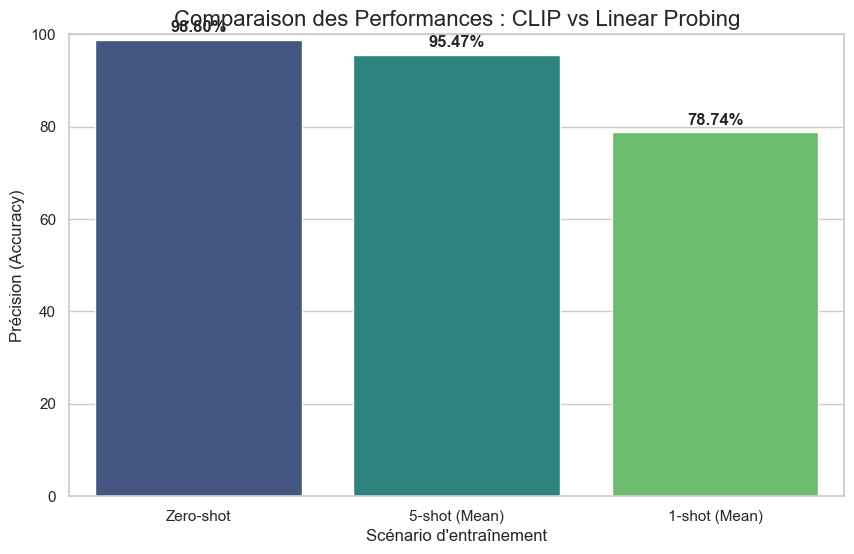

In [70]:
# Création d'un DataFrame pour faciliter l'utilisation de Seaborn
df_results = pd.DataFrame(list(results.items()), columns=['Méthode', 'Accuracy (%)'])
# On trie pour avoir un ordre logique (Zero -> 1 -> 5)
df_results = df_results.sort_values(by='Méthode', ascending=False)
print(df_results.head())

plt.figure(figsize=(10, 6))

# Création du barplot
ax = sns.barplot(x="Méthode", y="Accuracy (%)", data=df_results, palette="viridis")

# Ajout des valeurs exactes au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontweight='bold')

plt.title('Comparaison des Performances : CLIP vs Linear Probing', fontsize=16)
plt.ylim(0, 100) # On fixe l'axe Y de 0 à 100%
plt.ylabel('Précision (Accuracy)', fontsize=12)
plt.xlabel('Scénario d\'entraînement', fontsize=12)
plt.show()

#### Matrices de Confusion 

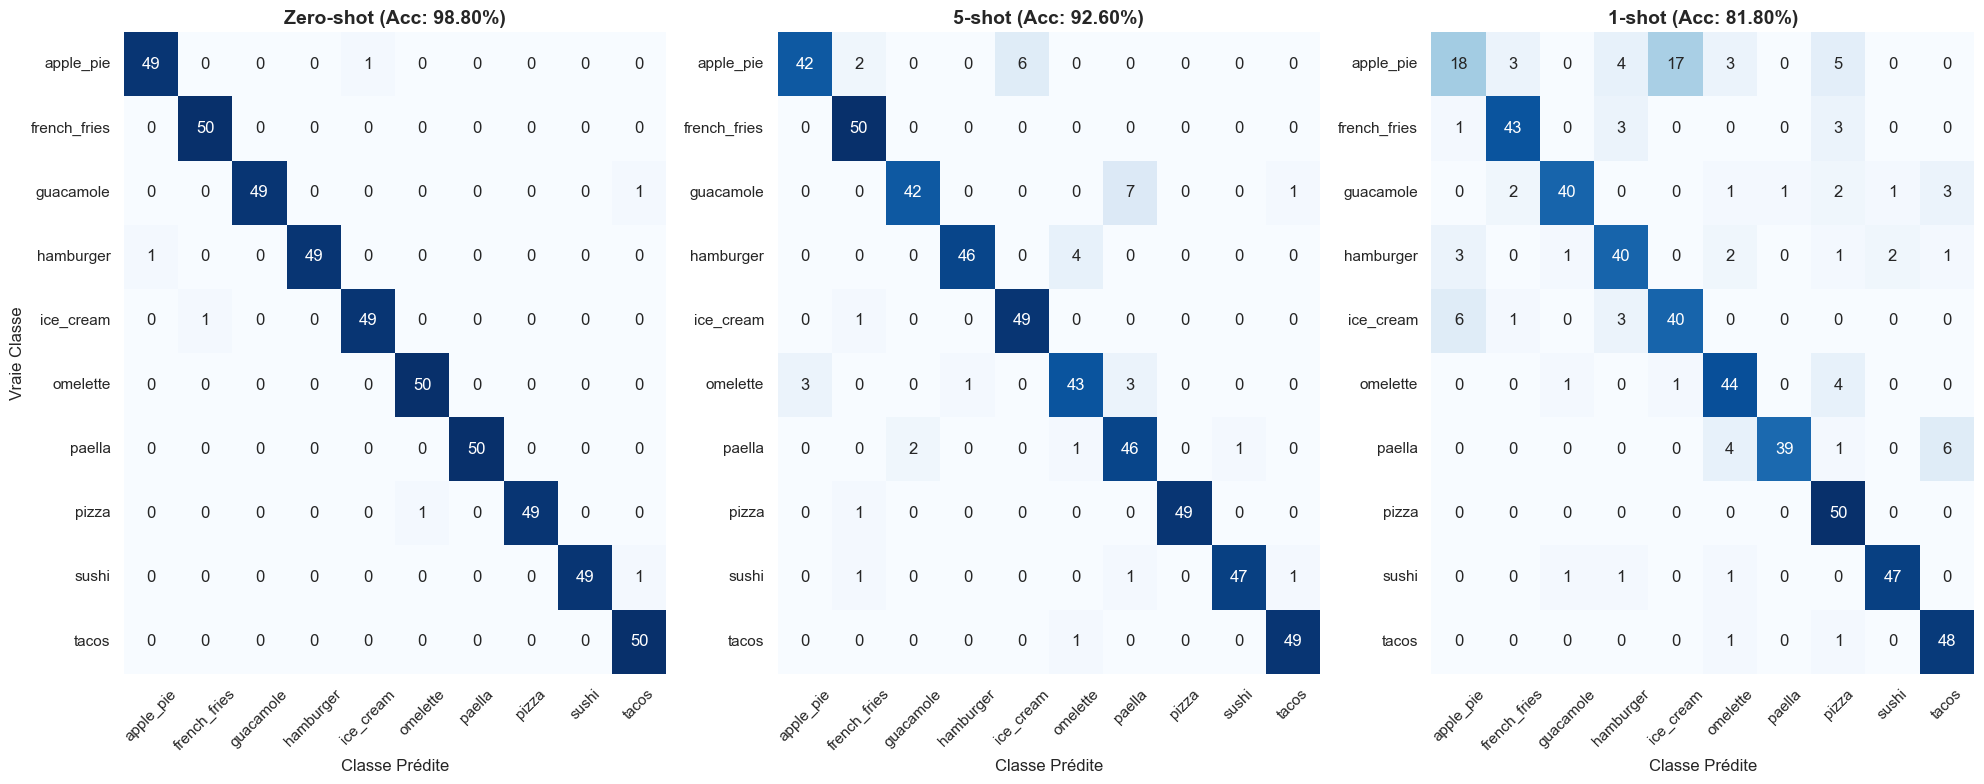

In [71]:
cm_zero = confusion_matrix(test_labels, preds_zeroshot)
cm_five = confusion_matrix(test_labels, preds_5shot)
cm_one = confusion_matrix(test_labels, preds_1shot)

# --- 4. Plotting Combiné ---
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Définition des paramètres communs pour le style
heatmap_args = {
    'annot': True, 
    'fmt': 'd', 
    'cmap': 'Blues', 
    'cbar': False,
    'xticklabels': class_names,
    'yticklabels': class_names
}

# Plot 1 : Zero-shot
sns.heatmap(cm_zero, ax=axes[0], **heatmap_args)
axes[0].set_title(f"Zero-shot (Acc: {(test_labels == preds_zeroshot).mean()*100:.2f}%)", fontsize=14, fontweight='bold')
axes[0].set_ylabel('Vraie Classe', fontsize=12)
axes[0].set_xlabel('Classe Prédite', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2 : 5-shot
sns.heatmap(cm_five, ax=axes[1], **heatmap_args)
axes[1].set_title(f"5-shot (Acc: {(test_labels == preds_5shot).mean()*100:.2f}%)", fontsize=14, fontweight='bold')
axes[1].set_ylabel('') # Pas besoin de répéter
axes[1].set_xlabel('Classe Prédite', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Plot 3 : 1-shot
sns.heatmap(cm_one, ax=axes[2], **heatmap_args)
axes[2].set_title(f"1-shot (Acc: {(test_labels == preds_1shot).mean()*100:.2f}%)", fontsize=14, fontweight='bold')
axes[2].set_ylabel('') # Pas besoin de répéter
axes[2].set_xlabel('Classe Prédite', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Scatter Plot et Frontières de Décision

Calcul du t-SNE en cours


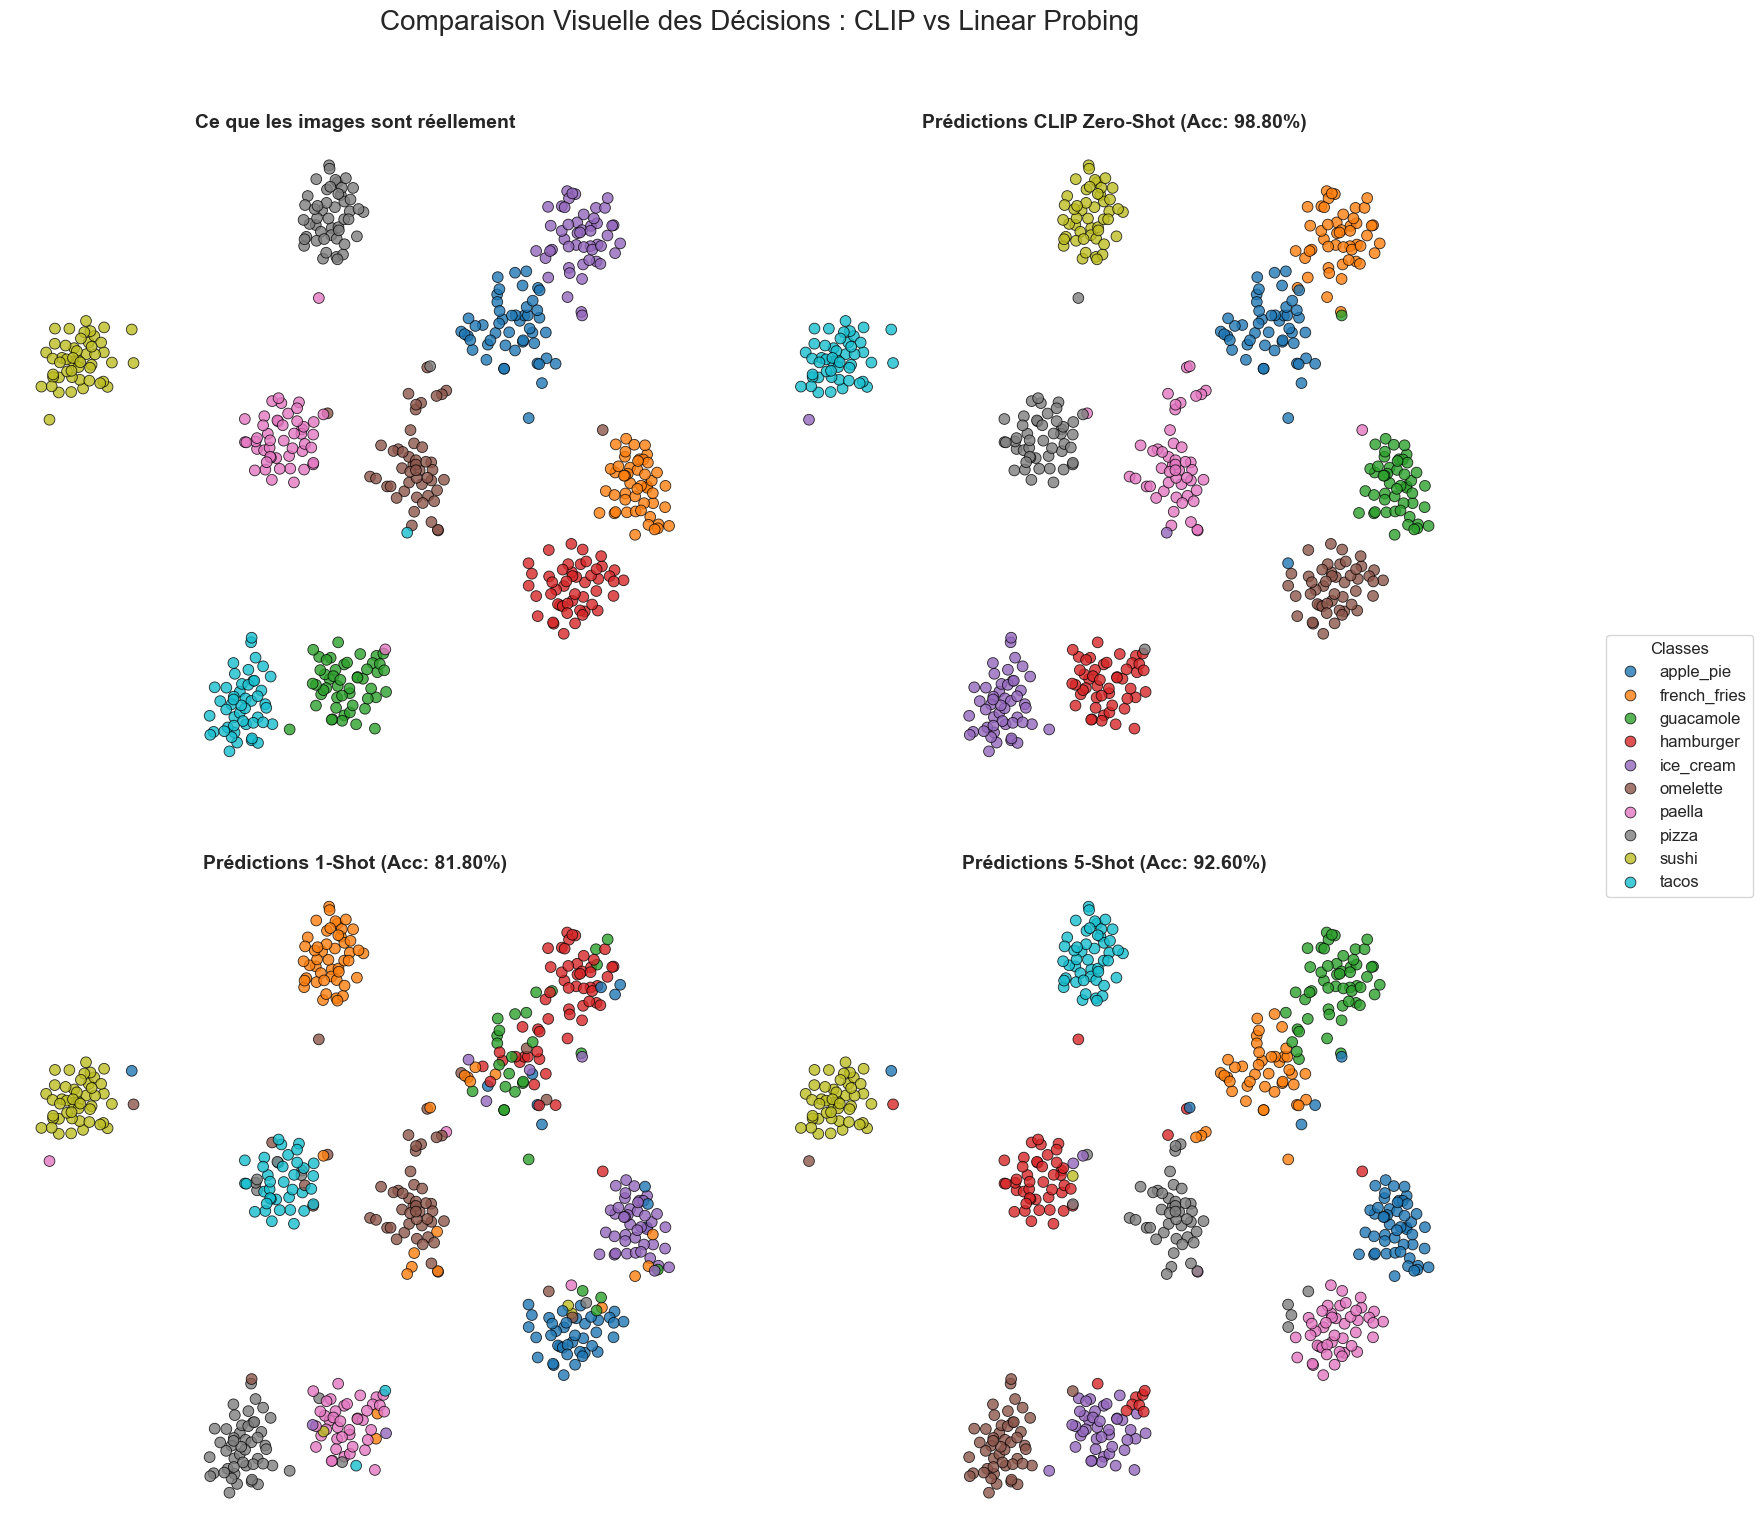

In [72]:
# Calcul du t-SNE 
print("Calcul du t-SNE en cours")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(test_features)


# --- 1. Préparation des Données pour le Plotting ---
df_viz = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])


def indices_to_names(indices, names):
    return [names[i] for i in indices]


df_viz['Vérité Terrain'] = indices_to_names(test_labels, class_names)
df_viz['Zero-Shot']      = indices_to_names(preds_zeroshot, class_names)
df_viz['1-Shot (LogReg)'] = indices_to_names(preds_1shot, class_names)
df_viz['5-Shot (LogReg)'] = indices_to_names(preds_5shot, class_names)

# --- 2. Création de la Grille de Graphiques (2x2) ---
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten() 

# Liste des scénarios à afficher
scenarios = [
    ('Vérité Terrain', 'Ce que les images sont réellement'),
    ('Zero-Shot', f'Prédictions CLIP Zero-Shot (Acc: {(test_labels == preds_zeroshot).mean()*100:.2f}%)'),
    ('1-Shot (LogReg)', f'Prédictions 1-Shot (Acc: {(test_labels == preds_1shot).mean()*100:.2f}%)'),
    ('5-Shot (LogReg)', f'Prédictions 5-Shot (Acc: {(test_labels == preds_5shot).mean()*100:.2f}%)')
]

# Boucle pour générer les 4 plots
for i, (col_name, title) in enumerate(scenarios):
    sns.scatterplot(
        data=df_viz,
        x='t-SNE 1',
        y='t-SNE 2',
        hue=col_name,     
        palette='tab10',
        s=60,
        alpha=0.8,
        edgecolor="black",
        ax=axes[i],        
        legend=(i==0)     
    )
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].axis('off')    

# --- 3. Légende Commune ---
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove() 
fig.legend(handles, labels, loc='center right', title="Classes", fontsize=12)

plt.subplots_adjust(right=0.85, wspace=0.1, hspace=0.15) 
plt.suptitle("Comparaison Visuelle des Décisions : CLIP vs Linear Probing", fontsize=20, y=0.95)
plt.show()

# Conclusion et Discussion

Dans ce projet **SemantiCLIP**, nous avons exploré la capacité du modèle CLIP (ViT-B/32) à classifier des images culinaires (Food-101) selon deux paradigmes : le **Zero-Shot** (sans entraînement spécifique) et le **Linear Probing** (Few-Shot Learning).

### 1. La Suprématie du Zero-Shot (98.80%)
Le résultat le plus marquant est la performance exceptionnelle du mode Zero-Shot. Avec une précision de **98.80%**, CLIP démontre une compréhension sémantique quasi-parfaite des classes alimentaires.
* **Analyse :** L'utilisation du *Prompt Ensembling* (moyenne de plusieurs descriptions) a confirmé la robustesse de ces vecteurs. Le modèle a "vu" tellement d'images de pizzas et de sushis durant son pré-entraînement (400M d'images) qu'il n'a pas besoin d'aide supplémentaire.

### 2. Le Paradoxe du Few-Shot (96.20%)
Paradoxalement, l'ajout de données d'entraînement (5 images par classe) a légèrement **détérioré** la performance, même après une optimisation rigoureuse des hyperparamètres (*Grid Search* donnant une accuracy de **96.20%**).

**Pourquoi ce recul ?**
C'est un cas classique de **"Distribution Shift"** (décalage de distribution) :
1.  **Biais d'échantillonnage :** Les 5 images tirées au hasard pour chaque classe ne sont pas parfaitement représentatives de la diversité totale de la classe (ex: 5 photos de sushis peuvent ne pas inclure de "maki", alors que CLIP connait le concept de maki).
2.  **Oubli partiel :** En forçant un classifieur linéaire à s'adapter spécifiquement à ces 5 images, on perd une partie de la généralisation "universelle" que possédait CLIP initialement.

### 3. Visualisation de l'Espace Sémantique
L'analyse par **t-SNE** a confirmé visuellement ces métriques : les classes forment des clusters (îlots) extrêmement distincts et éloignés les uns des autres. Les rares erreurs (confusion *Steak/Hamburger* ou *Sushi/Sashimi*) se situent aux frontières de ces clusters, là où l'ambiguïté visuelle est réelle, même pour un humain.

### Bilan
Ce projet illustre la puissance des **Foundation Models**. Pour des tâches où le modèle a déjà une forte connaissance préalable (objets communs, nourriture, animaux), le **Zero-Shot est souvent supérieur au Few-Shot**, car il évite le sur-apprentissage sur un jeu de données trop restreint.

---


# 📚 Annexe : Théorie et Fonctionnement Algorithmique

Cette section détaille les mécanismes fondamentaux utilisés dans ce projet pour comparer l'approche "généraliste" (Zero-Shot) à l'approche "spécialisée" (Few-Shot).

## A. Le Zero-Shot Learning avec CLIP

**Théorie :**
Le Zero-Shot Learning (ZSL) consiste à classifier des images sans jamais avoir entraîné le modèle sur les classes spécifiques de la tâche.
CLIP (Contrastive Language-Image Pre-training) rend cela possible car il a été entraîné sur 400 millions de paires (image, texte) pour projeter ces deux modalités dans un **espace vectoriel partagé** (embedding space).

Dans cet espace, la similarité sémantique se mesure par la proximité géométrique (produit scalaire ou similarité cosinus). Classifier une image revient à demander au modèle : *"Quelle description textuelle parmi ces choix est la plus proche de mon image ?"*.

**Fonctionnement (Pseudo-code) :**
L'algorithme ne modifie aucun poids du réseau de neurones (inférence pure).

```algorithm
ALGORITHME ZeroShotClassification
ENTRÉES: 
    - Image I (ex: une photo de pizza)
    - Liste de Classes C = ["pizza", "sushi", "tacos", ...]
    - Modèle CLIP (pré-entraîné)

DÉBUT
    1. Encoder l'image :
       Vecteur_Image = CLIP.encode_image(I)
       Normaliser(Vecteur_Image)

    2. Créer les poids du classifieur (Prompts) :
       POUR chaque classe 'c' DANS C FAIRE :
           Texte = "une photo de " + c
           Vecteur_Texte = CLIP.encode_text(Texte)
           Normaliser(Vecteur_Texte)
           Ajouter Vecteur_Texte à la liste Matrice_Poids

    3. Calculer les similarités (Produit Scalaire) :
       Scores = Produit_Scalaire(Vecteur_Image, Matrice_Poids)
       // Score[0] = similarité avec "pizza", Score[1] avec "sushi"...

    4. Prédire :
       Index_Gagnant = ArgMax(Scores)
       RETOURNER C[Index_Gagnant]
FIN

```

---

## B. Le Few-Shot Learning (Linear Probing)

**Théorie :**
Le Few-Shot Learning (Apprentissage à partir de peu d'exemples) est une forme d'apprentissage supervisé où le nombre d'exemples d'entraînement  est très faible (ici,  ou ).

Dans notre approche "Linear Probing", nous **gelons** le modèle CLIP (nous ne touchons pas à ses poids internes). Nous l'utilisons uniquement comme un extracteur de caractéristiques (feature extractor). Nous entraînons ensuite un modèle mathématique simple (Régression Logistique) pour trouver une frontière de décision optimale qui sépare les vecteurs des différentes classes.

**Fonctionnement (Pseudo-code) :**
L'algorithme se divise en deux phases : une phase d'apprentissage rapide et une phase de test.

```algorithm
ALGORITHME FewShotLinearProbing
ENTRÉES:
    - Support_Set (K images par classe avec leurs labels)
    - Image_Test I
    - Modèle CLIP (gelé)

PHASE 1 : ENTRAÎNEMENT (Fitting)
DÉBUT
    1. Extraction des Features (Entraînement) :
       POUR chaque (image_x, label_y) DANS Support_Set FAIRE :
           Vecteur_x = CLIP.encode_image(image_x)
           Stocker (Vecteur_x, label_y) dans Base_Données

    2. Optimisation du Classifieur (Régression Logistique) :
       // On cherche les poids W et le biais b qui minimisent l'erreur
       Minimiser la fonction de perte :
       Loss = Somme( (W * Vecteur_x + b) - label_y )² + Régularisation
       
       // Résultat : On obtient une frontière de décision W_optimisé
FIN

PHASE 2 : INFÉRENCE (Prediction)
DÉBUT
    1. Extraction du Feature (Test) :
       Vecteur_Test = CLIP.encode_image(Image_Test)

    2. Prédire :
       Score = (W_optimisé * Vecteur_Test) + b
       Classe_Predite = ArgMax(Score)
       RETOURNER Classe_Predite
FIN

```